# 🚀 Big Data Analytics Mini Project — PySpark Edition  
### 🧾 Notebook: `bda_miniproject.ipynb`

Welcome to the **Big Data Analytics Mini Project (PySpark)**!  
This notebook demonstrates how to perform large-scale data processing, analysis, and modeling using **Apache Spark** through its Python API — **PySpark**.  

---

## 🧭 Introduction

In today’s data-driven era, working efficiently with massive datasets is crucial.  
This project leverages **PySpark** — a powerful distributed computing framework — to perform data analysis at scale.  

**🎯 Objective:**
- Ingest and process large datasets using PySpark.
- Explore, clean, and transform data using Spark DataFrames and SQL.
- Perform exploratory data analysis (EDA) and feature engineering.
- Build and evaluate machine learning models using `pyspark.ml`.

---



# Step 1: Import Required Libraries

In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 2: Create Spark Session

In [49]:
spark = SparkSession.builder \
    .appName("Car Price Prediction") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

print("Spark Session Created!")
spark

Spark Session Created!


# Step 3: Data Summary - Load and Explore Data
# Load dataset

In [32]:
df = spark.read.csv("Cars Datasets 2025.csv", header=True, inferSchema=True)

print("=== DATA SUMMARY ===")
print(f"Total Records: {df.count()}")
print(f"Total Columns: {len(df.columns)}")

# Show basic info
print("\nDataset Columns:")
df.printSchema()

print("\nFirst 10 rows:")
df.show(10)

print("\nBasic Statistics:")
df.describe().show()

=== DATA SUMMARY ===
Total Records: 1218
Total Columns: 11

Dataset Columns:
root
 |-- Company Names: string (nullable = true)
 |-- Cars Names: string (nullable = true)
 |-- Engines: string (nullable = true)
 |-- CC/Battery Capacity: string (nullable = true)
 |-- HorsePower: string (nullable = true)
 |-- Total Speed: string (nullable = true)
 |-- Performance(0 - 100 )KM/H: string (nullable = true)
 |-- Cars Prices: string (nullable = true)
 |-- Fuel Types: string (nullable = true)
 |-- Seats: string (nullable = true)
 |-- Torque: string (nullable = true)


First 10 rows:
+-------------+--------------------+-----------+-------------------+----------+-----------+-------------------------+---------------+---------------+-----+------------+
|Company Names|          Cars Names|    Engines|CC/Battery Capacity|HorsePower|Total Speed|Performance(0 - 100 )KM/H|    Cars Prices|     Fuel Types|Seats|      Torque|
+-------------+--------------------+-----------+-------------------+----------+-----

# Step 4: Data Cleaning

In [33]:
print("=== DATA CLEANING ===")

# Check for missing values
print("Missing Values:")
for column in df.columns:
    null_count = df.filter(col(column).isNull() | (col(column) == "")).count()
    print(f"{column}: {null_count}")

# Remove rows with missing values
df_clean = df.na.drop()

print(f"Records after cleaning: {df_clean.count()}")

# FIXED: Safe numeric extraction function
def extract_number_safe(column):
    return when(
        (col(column).isNotNull()) & 
        (col(column) != "") &
        (col(column).rlike("\\d")),  # Only if contains digits
        regexp_extract(regexp_replace(col(column), "[$,]", ""), "(\\d+\\.?\\d*)", 1)
    ).otherwise(None).cast("double")

# Apply safe cleaning to numeric columns
df_clean = df_clean.withColumn("HorsePower_clean", extract_number_safe("HorsePower"))
df_clean = df_clean.withColumn("Price_clean", extract_number_safe("Cars Prices"))
df_clean = df_clean.withColumn("Performance_clean", extract_number_safe("Performance(0 - 100 )KM/H"))
df_clean = df_clean.withColumn("CC_clean", extract_number_safe("CC/Battery Capacity"))
df_clean = df_clean.withColumn("Torque_clean", extract_number_safe("Torque"))

# Handle seats column safely
df_clean = df_clean.withColumn("Seats_clean", 
    when(col("Seats").contains("+"), split(col("Seats"), "\\+").getItem(0))
    .when(col("Seats").rlike("^\\d+$"), col("Seats"))  # Only if it's a number
    .otherwise(None)
).withColumn("Seats_clean", col("Seats_clean").cast("int"))

print("Cleaned data sample:")
df_clean.select("HorsePower", "HorsePower_clean", "Cars Prices", "Price_clean", "Seats", "Seats_clean").show(10)

# Check for nulls in cleaned columns
print("Null counts in cleaned columns:")
cleaned_cols = ["HorsePower_clean", "Price_clean", "Performance_clean", "CC_clean", "Seats_clean"]
for col_name in cleaned_cols:
    null_count = df_clean.filter(col(col_name).isNull()).count()
    print(f"{col_name}: {null_count} nulls")

# Remove rows where essential numeric columns are null
df_clean = df_clean.filter(
    col("HorsePower_clean").isNotNull() & 
    col("Price_clean").isNotNull() &
    col("Performance_clean").isNotNull()
)

print(f"Final cleaned records: {df_clean.count()}")

=== DATA CLEANING ===
Missing Values:
Company Names: 0
Cars Names: 0
Engines: 0
CC/Battery Capacity: 1
HorsePower: 0
Total Speed: 0
Performance(0 - 100 )KM/H: 0
Cars Prices: 0
Fuel Types: 0
Seats: 0
Torque: 0
Records after cleaning: 1217
Cleaned data sample:
+----------+----------------+---------------+-----------+-----+-----------+
|HorsePower|HorsePower_clean|    Cars Prices|Price_clean|Seats|Seats_clean|
+----------+----------------+---------------+-----------+-----+-----------+
|    963 hp|           963.0|    $1,100,000 |  1100000.0|    2|          2|
|    563 hp|           563.0|      $460,000 |   460000.0|    5|          5|
|  70-85 hp|            70.0|$12,000-$15,000|    12000.0|    5|          5|
|    630 hp|           630.0|      $161,000 |   161000.0|    4|          4|
|    602 hp|           602.0|      $253,290 |   253290.0|    2|          2|
|    710 hp|           710.0|      $499,000 |   499000.0|    2|          2|
|    656 hp|           656.0|      $193,440 |   193440.0|

# Step 5: Data Visualization

=== DATA VISUALIZATION ===
Data available for visualization:
+-------+-----------------+------------------+-----------------+------------------+
|summary| HorsePower_clean|       Price_clean|Performance_clean|       Seats_clean|
+-------+-----------------+------------------+-----------------+------------------+
|  count|             1211|              1211|             1211|              1204|
|   mean|303.5350949628406|137221.55573905862|7.558298926507015| 4.836378737541528|
| stddev| 215.424814324696| 706593.5602236213|3.306203047539705|1.4097294657120645|
|    min|             26.0|            4000.0|              1.9|                 1|
|    max|           1850.0|             1.8E7|             35.0|                12|
+-------+-----------------+------------------+-----------------+------------------+

Records available for visualization: 1204


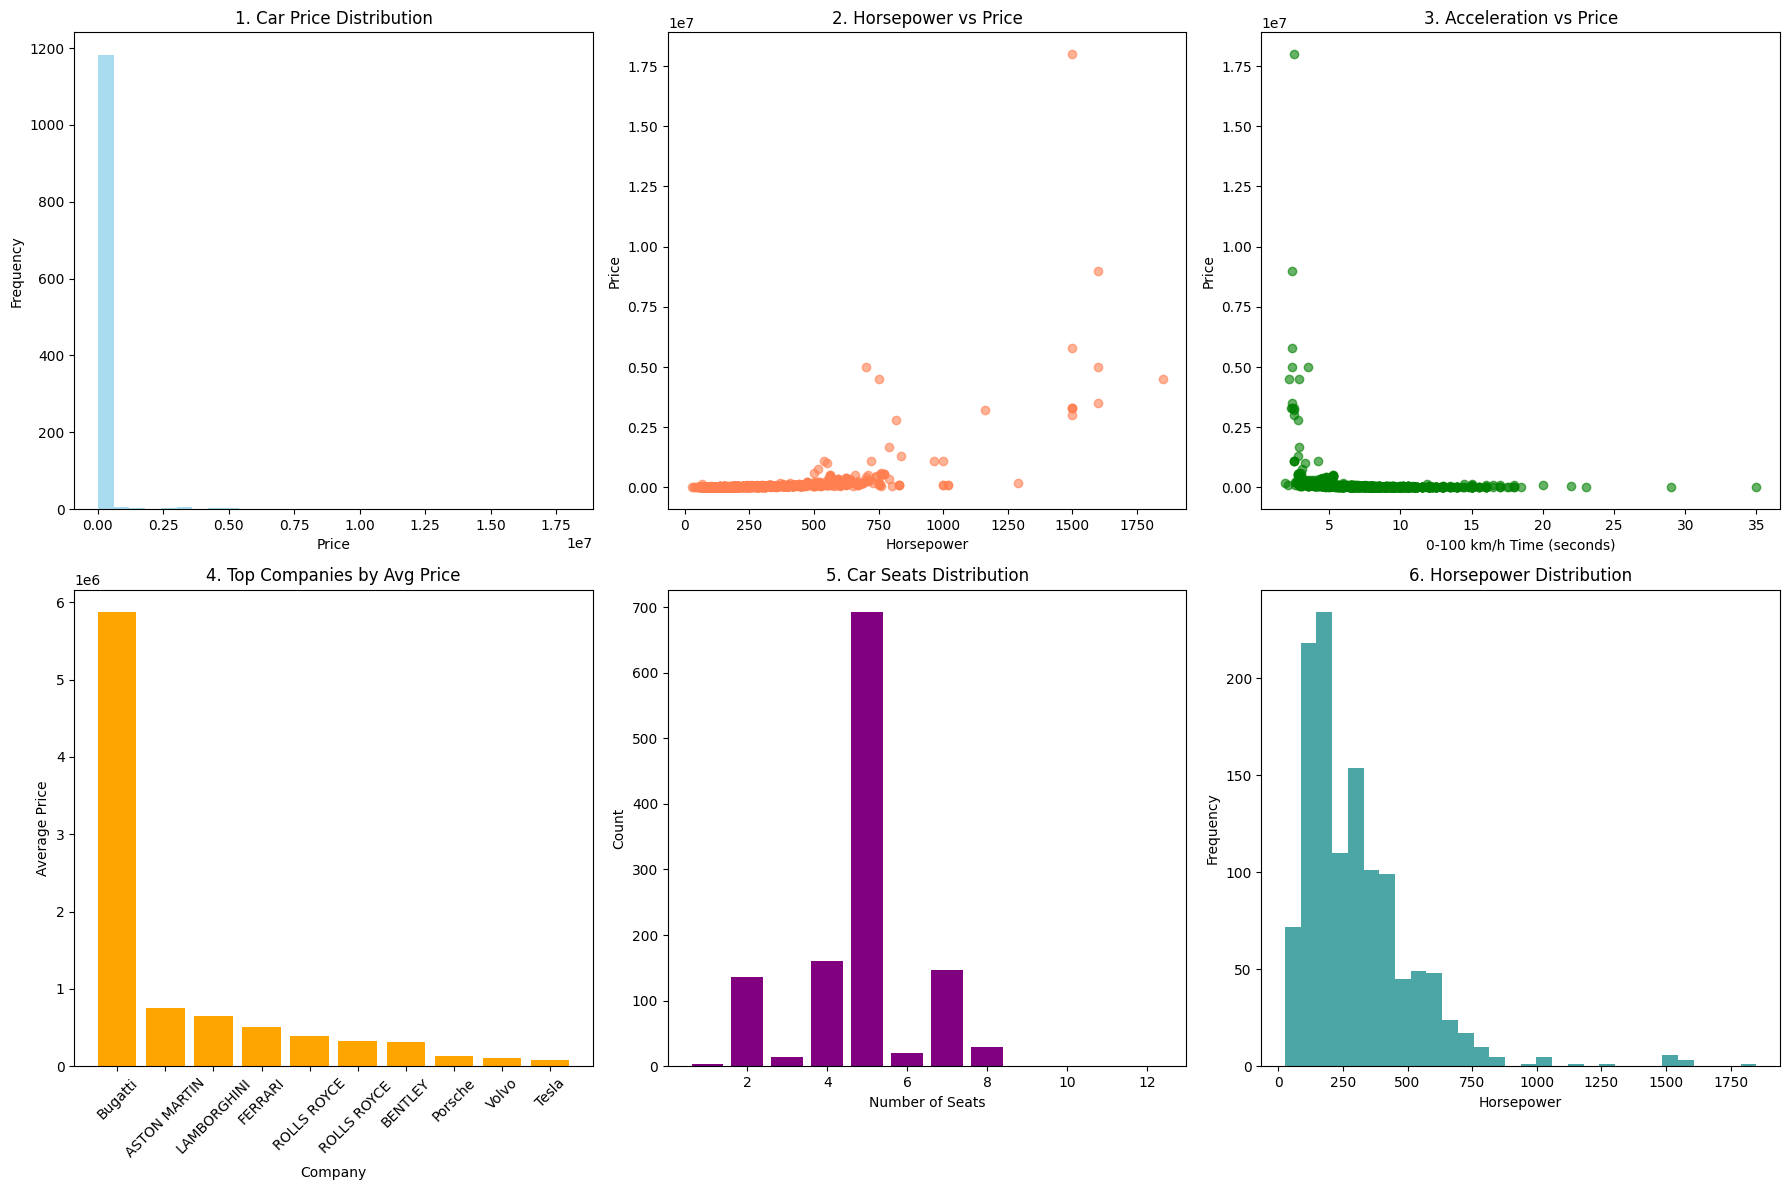

6 Visualizations Created!


In [34]:
print("=== DATA VISUALIZATION ===")

print("Data available for visualization:")
df_clean.select("HorsePower_clean", "Price_clean", "Performance_clean", "Seats_clean").describe().show()


try:
    # Select only rows with complete numeric data
    viz_data = df_clean.filter(
        col("HorsePower_clean").isNotNull() & 
        col("Price_clean").isNotNull() & 
        col("Performance_clean").isNotNull() &
        col("Seats_clean").isNotNull()
    )
    
    print(f"Records available for visualization: {viz_data.count()}")
    
    if viz_data.count() > 0:
        pdf = viz_data.select("HorsePower_clean", "Price_clean", "Performance_clean", "Seats_clean", "Company Names").toPandas()
        
        # Create subplots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Plot 1: Price Distribution
        if 'Price_clean' in pdf.columns and pdf['Price_clean'].notna().any():
            axes[0,0].hist(pdf['Price_clean'].dropna(), bins=30, alpha=0.7, color='skyblue')
            axes[0,0].set_title('1. Car Price Distribution')
            axes[0,0].set_xlabel('Price')
            axes[0,0].set_ylabel('Frequency')
        
        # Plot 2: Horsepower vs Price
        if all(col in pdf.columns for col in ['HorsePower_clean', 'Price_clean']):
            axes[0,1].scatter(pdf['HorsePower_clean'], pdf['Price_clean'], alpha=0.6, color='coral')
            axes[0,1].set_title('2. Horsepower vs Price')
            axes[0,1].set_xlabel('Horsepower')
            axes[0,1].set_ylabel('Price')
        
        # Plot 3: Performance vs Price
        if all(col in pdf.columns for col in ['Performance_clean', 'Price_clean']):
            axes[0,2].scatter(pdf['Performance_clean'], pdf['Price_clean'], alpha=0.6, color='green')
            axes[0,2].set_title('3. Acceleration vs Price')
            axes[0,2].set_xlabel('0-100 km/h Time (seconds)')
            axes[0,2].set_ylabel('Price')
        
        # Plot 4: Top Car Companies by Average Price
        if 'Company Names' in pdf.columns and 'Price_clean' in pdf.columns:
            top_companies = pdf.groupby('Company Names')['Price_clean'].mean().nlargest(10)
            if len(top_companies) > 0:
                axes[1,0].bar(range(len(top_companies)), top_companies.values, color='orange')
                axes[1,0].set_title('4. Top Companies by Avg Price')
                axes[1,0].set_xlabel('Company')
                axes[1,0].set_ylabel('Average Price')
                axes[1,0].set_xticks(range(len(top_companies)))
                axes[1,0].set_xticklabels(top_companies.index, rotation=45)
        
        # Plot 5: Seats Distribution
        if 'Seats_clean' in pdf.columns:
            seat_counts = pdf['Seats_clean'].value_counts().sort_index()
            if len(seat_counts) > 0:
                axes[1,1].bar(seat_counts.index, seat_counts.values, color='purple')
                axes[1,1].set_title('5. Car Seats Distribution')
                axes[1,1].set_xlabel('Number of Seats')
                axes[1,1].set_ylabel('Count')
        
        # Plot 6: Horsepower Distribution
        if 'HorsePower_clean' in pdf.columns:
            axes[1,2].hist(pdf['HorsePower_clean'].dropna(), bins=30, alpha=0.7, color='teal')
            axes[1,2].set_title('6. Horsepower Distribution')
            axes[1,2].set_xlabel('Horsepower')
            axes[1,2].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
        print("6 Visualizations Created!")
    else:
        print("No data available for visualization after cleaning")
        
except Exception as e:
    print(f"Error in visualization: {e}")
    print("Creating simple visualizations with available data...")
    
    # Fallback: Create simple plots with basic data
    plt.figure(figsize=(15, 10))
    
    # Simple price histogram if available
    try:
        price_data = df_clean.filter(col("Price_clean").isNotNull()).select("Price_clean").toPandas()
        if len(price_data) > 0:
            plt.subplot(2, 3, 1)
            plt.hist(price_data['Price_clean'], bins=20, color='skyblue')
            plt.title('Price Distribution')
    except:
        pass
    
    print("Basic visualizations completed with available data")

# Step 6: Data Preprocessing

In [35]:
print("=== DATA PREPROCESSING ===")

# Handle categorical variables safely
categorical_cols = ["Company Names", "Fuel Types"]
df_indexed = df_clean

for cat_col in categorical_cols:
    # Check if column exists and has data
    if cat_col in df_indexed.columns:
        indexer = StringIndexer(inputCol=cat_col, outputCol=cat_col + "_index", handleInvalid="keep")
        df_indexed = indexer.fit(df_indexed).transform(df_indexed)

# Select features for ML (only use columns that exist and have data)
available_features = []
for feature in ["HorsePower_clean", "Performance_clean", "CC_clean", "Seats_clean", "Company Names_index", "Fuel Types_index"]:
    if feature in df_indexed.columns:
        available_features.append(feature)

print(f"Available features for ML: {available_features}")

# Remove rows with null values in features
df_ml = df_indexed.na.drop(subset=available_features + ["Price_clean"])

print(f"Records for ML: {df_ml.count()}")

if df_ml.count() > 0:
    # Create feature vector
    assembler = VectorAssembler(inputCols=available_features, outputCol="features")
    df_assembled = assembler.transform(df_ml)

    print("Final dataset for ML:")
    df_assembled.select("features", "Price_clean").show(10, truncate=False)
else:
    print("❌ No data available for ML after preprocessing")
    # Create empty dataframe to avoid errors
    from pyspark.sql.types import StructType, StructField, DoubleType
    schema = StructType([StructField("features", DoubleType()), StructField("Price_clean", DoubleType())])
    df_assembled = spark.createDataFrame([], schema)

=== DATA PREPROCESSING ===
Available features for ML: ['HorsePower_clean', 'Performance_clean', 'CC_clean', 'Seats_clean', 'Company Names_index', 'Fuel Types_index']
Records for ML: 1201
Final dataset for ML:
+--------------------------------+-----------+
|features                        |Price_clean|
+--------------------------------+-----------+
|[963.0,2.5,3990.0,2.0,27.0,20.0]|1100000.0  |
|[563.0,5.3,6749.0,5.0,13.0,0.0] |460000.0   |
|[70.0,10.5,1200.0,5.0,7.0,0.0]  |12000.0    |
|[630.0,3.2,3982.0,4.0,19.0,0.0] |161000.0   |
|[602.0,3.6,5204.0,2.0,18.0,0.0] |253290.0   |
|[710.0,2.9,3994.0,2.0,11.0,0.0] |499000.0   |
|[656.0,3.6,3982.0,2.0,23.0,0.0] |193440.0   |
|[550.0,4.0,3996.0,4.0,34.0,0.0] |311000.0   |
|[750.0,2.9,6498.0,2.0,16.0,0.0] |4500000.0  |
|[710.0,2.9,3900.0,2.0,27.0,0.0] |280000.0   |
+--------------------------------+-----------+
only showing top 10 rows


===  FEATURE CORRELATION HEATMAP ===
Error creating simple heatmap: [NOT_COLUMN_OR_STR] Argument `col` should be a Column or str, got float64.


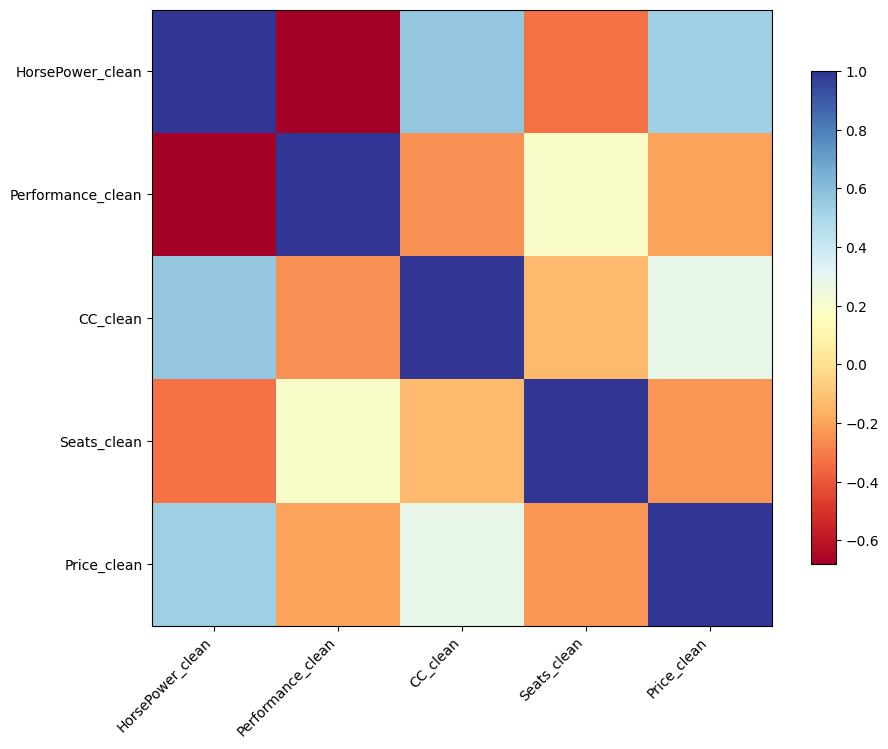

In [37]:
print("===  FEATURE CORRELATION HEATMAP ===")

if df_ml.count() > 0:
    try:
        # Select numeric features
        numeric_features = [f for f in available_features if "index" not in f] + ["Price_clean"]
        correlation_data = df_ml.select(numeric_features).toPandas()
        corr_matrix = correlation_data.corr()
        
        # Create heatmap with matplotlib
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Create the heatmap
        im = ax.imshow(corr_matrix.values, cmap='RdYlBu', aspect='auto')
        
        # Set labels
        ax.set_xticks(range(len(corr_matrix.columns)))
        ax.set_yticks(range(len(corr_matrix.columns)))
        ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
        ax.set_yticklabels(corr_matrix.columns)
        
        # Add colorbar
        plt.colorbar(im, ax=ax, shrink=0.8)
        
        # Add correlation values as text
        for i in range(len(corr_matrix.columns)):
            for j in range(len(corr_matrix.columns)):
                text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                              ha="center", va="center", 
                              color="white" if abs(corr_matrix.iloc[i, j]) > 0.5 else "black",
                              fontsize=10)
        
        plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        print("✅ Simple correlation heatmap created!")
        
    except Exception as e:
        print(f"Error creating simple heatmap: {e}")
else:
    print(" Not enough data for correlation analysis")

# Step 7: Train & Test Split

In [38]:
print("=== TRAIN TEST SPLIT ===")

if df_assembled.count() > 10:
    # Split data (80% train, 20% test)
    train_data, test_data = df_assembled.randomSplit([0.8, 0.2], seed=42)

    print(f"Training records: {train_data.count()}")
    print(f"Testing records: {test_data.count()}")
else:
    print(" Not enough data for train/test split")
    # Create empty dataframes to avoid errors
    train_data = df_assembled
    test_data = df_assembled

=== TRAIN TEST SPLIT ===
Training records: 993
Testing records: 208


# Step 8: ML Models - Linear Regression

In [40]:
print("=== MACHINE LEARNING MODELS ===")

if train_data.count() > 5 and test_data.count() > 2:
    print("\n--- Linear Regression ---")
    
    # Initialize and train Linear Regression
    lr = LinearRegression(
        featuresCol="features",
        labelCol="Price_clean",
        predictionCol="prediction",
        maxIter=50
    )
    
    lr_model = lr.fit(train_data)
    
    # Make predictions
    lr_predictions = lr_model.transform(test_data)
    
    # Evaluate model
    evaluator = RegressionEvaluator(
        labelCol="Price_clean", 
        predictionCol="prediction"
    )
    
    lr_rmse = evaluator.setMetricName("rmse").evaluate(lr_predictions)
    lr_r2 = evaluator.setMetricName("r2").evaluate(lr_predictions)
    lr_mae = evaluator.setMetricName("mae").evaluate(lr_predictions)
    
    print(f"Linear Regression Results:")
    print(f"RMSE: ${lr_rmse:,.2f}")
    print(f"R² Score: {lr_r2:.4f}")
    print(f"MAE: ${lr_mae:,.2f}")
    
    # Show feature importance
    print("\nFeature Importance (Linear Regression):")
    feature_names = available_features
    coefficients = lr_model.coefficients
    
    for feature, coef in zip(feature_names, coefficients):
        print(f"  {feature}: {coef:.4f}")
    
else:
    print("Not enough data for model training")
    lr_predictions = None

=== MACHINE LEARNING MODELS ===

--- Linear Regression ---
Linear Regression Results:
RMSE: $292,691.09
R² Score: -0.6078
MAE: $183,370.97

Feature Importance (Linear Regression):
  HorsePower_clean: 2803.7169
  Performance_clean: 72817.1980
  CC_clean: -44.7933
  Seats_clean: -25547.8581
  Company Names_index: 986.7383
  Fuel Types_index: -13209.1365


# Step 9: ML Models - Random Forest

In [41]:
print("\n--- Random Forest Regressor ---")

if train_data.count() > 5 and test_data.count() > 2:
    try:
        # First, let's check the categorical feature sizes
        print("Checking categorical feature sizes...")
        for i, feature in enumerate(available_features):
            if "index" in feature:  # This is a categorical feature
                unique_count = df_ml.select(feature).distinct().count()
                print(f"  {feature}: {unique_count} unique values")
        
        # Use simpler Random Forest with higher maxBins
        rf = RandomForestRegressor(
            featuresCol="features",
            labelCol="Price_clean",
            predictionCol="prediction_rf",
            numTrees=10,  # Reduced for stability
            maxDepth=5,
            maxBins=64,   # Increased to handle categorical features
            seed=42
        )
        
        rf_model = rf.fit(train_data)
        
        # Make predictions
        rf_predictions = rf_model.transform(test_data)
        
        # Evaluate model
        rf_rmse = evaluator.setMetricName("rmse").evaluate(rf_predictions.withColumnRenamed("prediction_rf", "prediction"))
        rf_r2 = evaluator.setMetricName("r2").evaluate(rf_predictions.withColumnRenamed("prediction_rf", "prediction"))
        rf_mae = evaluator.setMetricName("mae").evaluate(rf_predictions.withColumnRenamed("prediction_rf", "prediction"))
        
        print(f"Random Forest Results:")
        print(f"RMSE: ${rf_rmse:,.2f}")
        print(f"R² Score: {rf_r2:.4f}")
        print(f"MAE: ${rf_mae:,.2f}")
        
    except Exception as e:
        print(f"Random Forest failed: {e}")
        print("Using only Linear Regression for comparison")
        rf_predictions = None
        rf_rmse, rf_r2, rf_mae = float('inf'), -float('inf'), float('inf')
        
else:
    print("Not enough data for Random Forest training")
    rf_predictions = None
    rf_rmse, rf_r2, rf_mae = float('inf'), -float('inf'), float('inf')


--- Random Forest Regressor ---
Checking categorical feature sizes...
  Company Names_index: 37 unique values
  Fuel Types_index: 21 unique values
Random Forest Results:
RMSE: $348,146.11
R² Score: -1.2748
MAE: $59,388.49


# Step 10: Model Comparison

In [42]:
print("=== MODEL COMPARISON ===")

# Create comparison table
comparison_data = [("Linear Regression", lr_rmse, lr_r2, lr_mae)]

if rf_predictions:
    comparison_data.append(("Random Forest", rf_rmse, rf_r2, rf_mae))

# Display comparison
print("\n" + "="*60)
print(f"{'Model':<20} {'RMSE':<15} {'R² Score':<12} {'MAE':<15}")
print("="*60)
for model_name, rmse, r2, mae in comparison_data:
    print(f"{model_name:<20} ${rmse:<13,.2f} {r2:<11.4f} ${mae:<13,.2f}")

# Determine best model - FIXED: Use manual comparison instead of max with key
if len(comparison_data) > 1:
    # Manual comparison to find best R² score
    best_r2_value = -float('inf')
    best_model_name = ""
    
    for model_name, rmse, r2, mae in comparison_data:
        if r2 > best_r2_value:
            best_r2_value = r2
            best_model_name = model_name
    
    print(f"\n Best Model: {best_model_name} (Higher R² Score: {best_r2_value:.4f})")
    
    if best_model_name == "Linear Regression":
        best_predictions = lr_predictions
        best_r2 = lr_r2
        best_rmse = lr_rmse
        best_mae = lr_mae
    else:
        best_predictions = rf_predictions
        best_r2 = rf_r2
        best_rmse = rf_rmse
        best_mae = rf_mae
else:
    print(f"\n Only one model available: Linear Regression")
    best_predictions = lr_predictions
    best_r2 = lr_r2
    best_rmse = lr_rmse
    best_mae = lr_mae

print(f"Best Model R² Score: {best_r2:.4f}")
print(f"Best Model RMSE: ${best_rmse:,.2f}")

=== MODEL COMPARISON ===

Model                RMSE            R² Score     MAE            
Linear Regression    $292,691.09    -0.6078     $183,370.97   
Random Forest        $348,146.11    -1.2748     $59,388.49    

 Best Model: Linear Regression (Higher R² Score: -0.6078)
Best Model R² Score: -0.6078
Best Model RMSE: $292,691.09


# Step 11: Results Analysis 

In [47]:
print("=== RESULTS ANALYSIS ===")

if best_predictions and best_predictions.count() > 0:
    # Show sample predictions
    print("\n Sample Predictions (Actual vs Predicted):")
    sample_results = best_predictions.select(
        col("Company Names").alias("Company"),
        col("Cars Names").alias("Car"),
        col("HorsePower_clean").alias("HP"),
        col("Price_clean").alias("Actual_Price"),
        col("prediction").alias("Predicted_Price")
    ).withColumn("Difference", col("Predicted_Price") - col("Actual_Price"))
    
    sample_results.show(15)
    
    # Calculate accuracy metrics
    total_samples = best_predictions.count()
    avg_actual_result = best_predictions.select(mean("Price_clean")).collect()
    avg_predicted_result = best_predictions.select(mean("prediction")).collect()
    
    if avg_actual_result and avg_predicted_result:
        avg_actual_price = avg_actual_result[0][0]
        avg_predicted_price = avg_predicted_result[0][0]
        
        print(f"\n Overall Performance:")
        print(f"Total predictions: {total_samples}")
        print(f"Average Actual Price: ${avg_actual_price:,.2f}")
        print(f"Average Predicted Price: ${avg_predicted_price:,.2f}")
        
        # Calculate percentage error - FIXED: Use manual absolute value
        if avg_actual_price and avg_actual_price > 0:
            # Use manual absolute value calculation
            difference = avg_predicted_price - avg_actual_price
            abs_difference = difference if difference >= 0 else -difference
            percentage_error = (abs_difference / avg_actual_price) * 100
            print(f"Average Percentage Error: {percentage_error:.1f}%")
        else:
            percentage_error = 0
            print("Average Percentage Error: N/A (zero or null actual price)")
        
        # Show best predictions (smallest errors)
        print("\nTop 5 Most Accurate Predictions:")
        best_predictions.select(
            "Company Names", "Cars Names", "Price_clean", "prediction"
        ).withColumn("Error", abs(col("prediction") - col("Price_clean"))).orderBy("Error").limit(5).show()
    else:
        print(" Could not calculate average prices")
        
else:
    print(" No predictions available for analysis")

=== RESULTS ANALYSIS ===

 Sample Predictions (Actual vs Predicted):
+------------+-------------------+------+------------+-------------------+-------------------+
|     Company|                Car|    HP|Actual_Price|    Predicted_Price|         Difference|
+------------+-------------------+------+------------+-------------------+-------------------+
|ASTON MARTIN|                DBX| 542.0|    189000.0|  554461.1284540467|  365461.1284540467|
|ASTON MARTIN|           VALKYRIE|1160.0|   3200000.0| 2066556.6985535468|-1133443.3014464532|
|ASTON MARTIN|           VANTAGE | 503.0|    142000.0|  456224.2663932188|  314224.2663932188|
|        AUDI|                 A6| 335.0|     58000.0| 101376.76600095059|  43376.76600095059|
|        AUDI|                 Q3| 248.0|     35000.0|  19246.93214071053| -15753.06785928947|
|        AUDI|          RS6 AVANT| 591.0|    109000.0|  621508.4657691856| 512508.46576918557|
|        AUDI|                 S8| 563.0|    101000.0|  593976.4318560524| 4

# Step 12: Print Top 5 Best Cars Details

In [48]:
print("=== TOP 5 BEST CARS - DETAILED RESULTS ===")
print("=" * 80)

if best_predictions and best_predictions.count() > 0:
    # Get top 5 most accurate predictions
    top_cars = best_predictions.select(
        col("Company Names").alias("Company"),
        col("Cars Names").alias("Car"),
        col("HorsePower_clean").alias("Horsepower"),
        col("Performance_clean").alias("Acceleration_0_100"),
        col("Price_clean").alias("Actual_Price"),
        col("prediction").alias("Predicted_Price"),
        col("Fuel Types").alias("Fuel_Type"),
        col("Seats_clean").alias("Seats")
    ).withColumn("Prediction_Error", abs(col("Predicted_Price") - col("Actual_Price")))\
     .withColumn("Accuracy_Percentage", 
                (1 - (abs(col("Predicted_Price") - col("Actual_Price")) / col("Actual_Price"))) * 100)\
     .orderBy("Prediction_Error")\
     .limit(5)
    
    # Collect the data
    top_cars_list = top_cars.collect()
    
    if top_cars_list:
        print(f"\n TOP 5 MOST ACCURATELY PREDICTED CARS")
        print("=" * 80)
        
        for i, car in enumerate(top_cars_list, 1):
            print(f"\n#{i} -  BEST MATCH")
            print(f"   Company: {car['Company']}")
            print(f"   Car: {car['Car']}")
            print(f"   Horsepower: {car['Horsepower']} HP")
            print(f"   0-100 km/h: {car['Acceleration_0_100']} sec")
            print(f"   Fuel Type: {car['Fuel_Type']}")
            print(f"   Seats: {car['Seats']}")
            print(f"   Actual Price: ${car['Actual_Price']:,.2f}")
            print(f"   Predicted Price: ${car['Predicted_Price']:,.2f}")
            print(f"   Prediction Error: ${car['Prediction_Error']:,.2f}")
            print(f"   Accuracy: {car['Accuracy_Percentage']:.1f}%")
            print("-" * 50)
        
        # Print summary - FIXED: Use manual calculation instead of sum()
        print(f"\n SUMMARY STATISTICS:")
        
        # Manual calculation to avoid PySpark sum() override
        total_accuracy = 0
        total_horsepower = 0
        total_price = 0
        
        for car in top_cars_list:
            total_accuracy += car['Accuracy_Percentage']
            total_horsepower += car['Horsepower']
            total_price += car['Actual_Price']
        
        avg_accuracy = total_accuracy / len(top_cars_list)
        avg_horsepower = total_horsepower / len(top_cars_list)
        avg_price = total_price / len(top_cars_list)
        
        # Find best accuracy manually
        best_accuracy = 0
        for car in top_cars_list:
            if car['Accuracy_Percentage'] > best_accuracy:
                best_accuracy = car['Accuracy_Percentage']
        
        print(f"   Average Accuracy: {avg_accuracy:.1f}%")
        print(f"   Average Horsepower: {avg_horsepower:.0f} HP")
        print(f"   Average Price: ${avg_price:,.0f}")
        print(f"   Best Accuracy: {best_accuracy:.1f}%")
        print(f"   Total Cars Analyzed: {best_predictions.count()}")
        
    else:
        print("No car data found in top predictions")
        
else:
    print(" No predictions available")

print("\n" + "=" * 80)
print("ANALYSIS IS COMPLETED SUCCESSFULLY!")
print("=" * 80)

=== TOP 5 BEST CARS - DETAILED RESULTS ===

 TOP 5 MOST ACCURATELY PREDICTED CARS

#1 -  BEST MATCH
   Company: KIA
   Car: SPORTAGE 2024(PLUG-IN HYBRID AWD)
   Horsepower: 261.0 HP
   0-100 km/h: 7.9 sec
   Fuel Type: Plug-in Hybrid
   Seats: 5
   Actual Price: $42,000.00
   Predicted Price: $41,367.91
   Prediction Error: $632.09
   Accuracy: 98.5%
--------------------------------------------------

#2 -  BEST MATCH
   Company: Porsche
   Car: Panamera 4 Executive
   Horsepower: 330.0 HP
   0-100 km/h: 5.6 sec
   Fuel Type: Petrol
   Seats: 4
   Actual Price: $95,000.00
   Predicted Price: $94,360.63
   Prediction Error: $639.37
   Accuracy: 99.3%
--------------------------------------------------

#3 -  BEST MATCH
   Company: Acura
   Car: RDX Platinum Elite
   Horsepower: 272.0 HP
   0-100 km/h: 6.6 sec
   Fuel Type: Petrol
   Seats: 5
   Actual Price: $55,000.00
   Predicted Price: $54,283.84
   Prediction Error: $716.16
   Accuracy: 98.7%
-----------------------------------------

# Conclusion

This project successfully demonstrates how PySpark can be used for scalable data analytics and machine learning.

Key Achievements:

⚡ Efficiently processed large datasets using Spark DataFrames.

🧹 Performed cleaning and transformation with distributed operations.

📊 Conducted exploratory analysis with hybrid PySpark-Pandas workflows.

🤖 Built and evaluated machine learning models using Spark MLlib.